# Task



1. Complete the ‘LTV’ tab - either in the suggested format or your own. We need to know the LTV for 2020 to make the right decisions moving forward. 

2. There is an error in the sales data! One school has the country tagged incorrectly. Identify which school this is, correct the data and call out the school name so we can root cause the issue. 

3. Generate an annual summary for the board and key investors (static). 

4. Configure a monthly report the Marketing and Sales teams can use by refreshing the data in each of the tabs (dynamic).

# 1: Importing Libraries 

In [1]:
import pandas as pd # data import, clean-up, exploration, and analysis
import numpy as np # numerical data functionality
import matplotlib.pyplot as plt #– data visualization
%matplotlib inline
import seaborn as sns #– data visualization 2.0
import re # text preprocessing
import datetime # date time manipulation 
import qgrid # dynamic view of dataframe with look up 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # widgets for interactivity 
import cufflinks as cf # dynamic graphs
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.express as px  #ploting library using js for dynamics


# set all rows to display
pd.options.display.max_rows = None # show all rows

## 1.1 Load in excel data as .csv into pandas dataframe.
### ----Important Note----
- The Intial implementation was to load the csv into a pandas dataframe but you will have to do some extra data cleaning. Such as droping the NaN columns,
using regular expressions to remove the $ sign from the ['Revenue amount'] and lastly type swapping it from 'object' to 'int64'

- I will leave the code process here so you can compare the difference as oppose to using pandas excellent read_excel function, which I found during my research.



In [2]:
# Faster implementation using read_excel
# Sales data Sheet
workbook_df = pd.read_excel('/Users/jtc/Data_Science_Projects/SAM_labs/sam_ex.xlsx',
                           sheet_name=['Sales data']) # add sheets seperated by comma 
sam = pd.concat(workbook_df[frame] for frame in workbook_df.keys())

# Competitor Data Sheet
workbook_df2 = pd.read_excel('/Users/jtc/Data_Science_Projects/SAM_labs/sam_ex.xlsx',
                           sheet_name=['Competitor Data']) # add sheets seperated by comma

competitors = pd.concat(workbook_df2[frame] for frame in workbook_df2.keys())

In [3]:
# if you are using the faster implementation do not run this cell 
#sam = pd.read_csv('/Users/jtc/Data_Science_Projects/SAM_labs/sam.csv')

## 2. Data Wrangling
- Formatting Column Names.
- This allows for easier Accessibility when using a data frame.

In [4]:
# format column names so they are easier to access
sam.rename(
    columns={
        'Order number':'OrderNumber',
        'Customer Name':'CustomerName',
        'Revenue amount':'RevenueAmount'
    },inplace=True
)

### 2.1 Adding row to categorize by month 
- This is primarly for the cohort analysis to track LTV.

In [5]:
sam['Month'] = pd.DatetimeIndex(sam['Date']).month
sam.head()

,OrderNumber,CustomerName,Country,RevenueAmount,Date,Month
0,SAM_LABS_1,School 1,United States,2532,2020-04-24,4
1,SAM_LABS_2,School 2,United States,2384,2020-08-13,8
2,SAM_LABS_3,School 3,Italy,1842,2020-09-10,9
3,SAM_LABS_4,School 4,Italy,2150,2020-06-04,6
4,SAM_LABS_5,School 5,Spain,1638,2020-04-08,4


### 2.2 Check for null/nan values for the entire dataframe.
    Check the shape of the data. rows: 2024 , cols: 5
    Check for null values among the 2024.

In [6]:
sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   OrderNumber    2024 non-null   object        
 1   CustomerName   2024 non-null   object        
 2   Country        2024 non-null   object        
 3   RevenueAmount  2024 non-null   int64         
 4   Date           2024 non-null   datetime64[ns]
 5   Month          2024 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 95.0+ KB


## 3. Cohort Analysis


#### 3.1 Creating OrderPeriod column 

In [7]:
sam['OrderPeriod'] = sam.Date.apply(lambda x: x.strftime('%Y-%m'))
sam.head()

,OrderNumber,CustomerName,Country,RevenueAmount,Date,Month,OrderPeriod
0,SAM_LABS_1,School 1,United States,2532,2020-04-24,4,2020-04
1,SAM_LABS_2,School 2,United States,2384,2020-08-13,8,2020-08
2,SAM_LABS_3,School 3,Italy,1842,2020-09-10,9,2020-09
3,SAM_LABS_4,School 4,Italy,2150,2020-06-04,6,2020-06
4,SAM_LABS_5,School 5,Spain,1638,2020-04-08,4,2020-04


#### 3.2 Creating Cohort column to organize clients

In [8]:
sam.set_index('CustomerName', inplace = True)

sam['CohortGroup'] = sam.groupby(level=0)['Date'].min().apply(lambda x: x.strftime('%Y-%m'))
sam.reset_index(inplace=True)
sam.head()

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup
0,School 1,SAM_LABS_1,United States,2532,2020-04-24,4,2020-04,2020-04
1,School 2,SAM_LABS_2,United States,2384,2020-08-13,8,2020-08,2020-08
2,School 3,SAM_LABS_3,Italy,1842,2020-09-10,9,2020-09,2020-09
3,School 4,SAM_LABS_4,Italy,2150,2020-06-04,6,2020-06,2020-06
4,School 5,SAM_LABS_5,Spain,1638,2020-04-08,4,2020-04,2020-04


#### 3.3 Column Aggregation 
    -Grouping New Users each cohort
    -Counting New Customers 
    -Counting revenue from those customers

In [9]:
grouped = sam.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'CustomerName': pd.Series.nunique,
                       'OrderNumber': pd.Series.nunique,
                       'RevenueAmount': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'CustomerName': 'Total New Customers',
                        'OrderNumber': 'TotalOrders'}, inplace=True)
cohorts.head(12)

Total New Customers  TotalOrders  RevenueAmount
CohortGroup OrderPeriod                                                 
2020-01     2020-01                      158          162         373235
            2020-02                        4            5          13047
            2020-03                        7            7          16041
            2020-04                        5            6          12867
            2020-05                       10           12          28342
            2020-06                        7            7          16495
            2020-07                        3            5          10268
            2020-08                        9            9          17553
            2020-09                        6            6          13284
            2020-10                        7            7          15992
            2020-11                       10           11          26393
            2020-12                       12           13          28958

#### 3.4 Creating a cohort period column

In [10]:

def cohort_period(sam):
    sam['CohortPeriod'] = np.arange(len(sam)) + 1
    return sam

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(12)

Total New Customers  TotalOrders  RevenueAmount  \
CohortGroup OrderPeriod                                                    
2020-01     2020-01                      158          162         373235   
            2020-02                        4            5          13047   
            2020-03                        7            7          16041   
            2020-04                        5            6          12867   
            2020-05                       10           12          28342   
            2020-06                        7            7          16495   
            2020-07                        3            5          10268   
            2020-08                        9            9          17553   
            2020-09                        6            6          13284   
            2020-10                        7            7          15992   
            2020-11                       10           11          26393   
            2020-12                       12           13          28958   

                         CohortPeriod  
CohortGroup OrderPeriod                
2020-01     2020-01                 1  
            2020-02                 2  
            2020-03                 3  
            2020-04                 4  
            2020-05                 5  
            2020-06                 6  
            2020-07                 7  
            2020-08                 8  
            2020-09                 9  
            2020-10                10  
            2020-11                11  
            2020-12                12

In [11]:
x = sam[(sam.CohortGroup == '2020-01') & (sam.OrderPeriod == '2020-01')]
y = cohorts.loc[('2020-01', '2020-01')]

assert(x['CustomerName'].nunique() == y['Total New Customers'])
assert(x['RevenueAmount'].sum().round(2) == y['RevenueAmount'].round(2))
assert(x['OrderNumber'].nunique() == y['TotalOrders'])

x = sam[(sam.CohortGroup == '2020-01') & (sam.OrderPeriod == '2020-09')]
y = cohorts.loc[('2020-01', '2020-09')]

assert(x['CustomerName'].nunique() == y['Total New Customers'])
assert(x['RevenueAmount'].sum().round(2) == y['RevenueAmount'].round(2))
assert(x['OrderNumber'].nunique() == y['TotalOrders'])

x = sam[(sam.CohortGroup == '2020-05') & (sam.OrderPeriod == '2020-09')]
y = cohorts.loc[('2020-05', '2020-09')]

assert(x['CustomerName'].nunique() == y['Total New Customers'])
assert(x['RevenueAmount'].sum().round(2) == y['RevenueAmount'].round(2))
assert(x['OrderNumber'].nunique() == y['TotalOrders'])

#### 3.5 Total Size of Cohort Group by Month

In [12]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['Total New Customers'].groupby(level=0).first()
cohort_group_size.head(12)

CohortGroup
2020-01    158
2020-02    147
2020-03    163
2020-04    147
2020-05    153
2020-06    145
2020-07    127
2020-08    132
2020-09    130
2020-10    126
2020-11    125
2020-12    111
Name: Total New Customers, dtype: int64

#### 4. Cohort Retention

In [13]:
cohorts['Total New Customers'].unstack(0).head(12)

CohortGroup,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
CohortPeriod,,,,,,,,,,,,
1,158.0,147.0,163.0,147.0,153.0,145.0,127.0,132.0,130.0,126.0,125.0,111.0
2,4.0,8.0,7.0,3.0,3.0,4.0,1.0,3.0,3.0,6.0,4.0,NaN
3,7.0,8.0,7.0,3.0,4.0,6.0,2.0,3.0,4.0,5.0,NaN,NaN
4,5.0,6.0,4.0,4.0,3.0,4.0,5.0,6.0,1.0,NaN,NaN,NaN
5,10.0,2.0,10.0,4.0,9.0,3.0,4.0,2.0,NaN,NaN,NaN,NaN
6,7.0,7.0,2.0,7.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN
7,3.0,4.0,1.0,2.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
8,9.0,7.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6.0,2.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
user_retention = cohorts['Total New Customers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(12)

CohortGroup,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
CohortPeriod,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.0
2,0.025316,0.054422,0.042945,0.020408,0.019608,0.027586,0.007874,0.022727,0.023077,0.047619,0.032,NaN
3,0.044304,0.054422,0.042945,0.020408,0.026144,0.041379,0.015748,0.022727,0.030769,0.039683,NaN,NaN
4,0.031646,0.040816,0.024540,0.027211,0.019608,0.027586,0.039370,0.045455,0.007692,NaN,NaN,NaN
5,0.063291,0.013605,0.061350,0.027211,0.058824,0.020690,0.031496,0.015152,NaN,NaN,NaN,NaN
6,0.044304,0.047619,0.012270,0.047619,0.032680,0.027586,0.055118,NaN,NaN,NaN,NaN,NaN
7,0.018987,0.027211,0.006135,0.013605,0.006536,0.041379,NaN,NaN,NaN,NaN,NaN,NaN
8,0.056962,0.047619,0.061350,0.013605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.037975,0.013605,0.042945,0.027211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4.1 Cohort Retention Plot

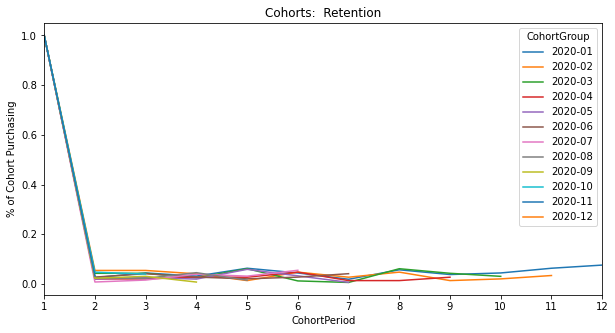

In [15]:
user_retention[['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']].plot(figsize=(10,5))
plt.title('Cohorts:  Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

### 5. HeatMap:  Retention

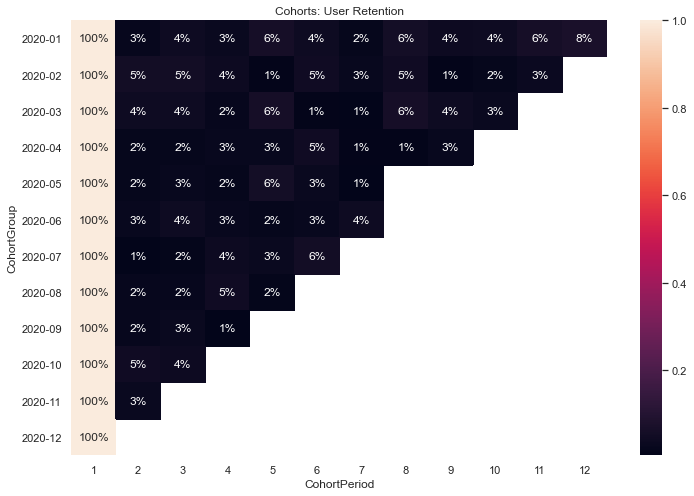

In [16]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

## 6. Monthly Revenue

In [17]:
revenue_by_month = sam.groupby(sam['Date'].dt.strftime('%B'))['RevenueAmount'].sum().sort_values(ascending=False)

revenue_by_month

Date
May          416037
March        409462
November     399712
June         390493
September    388067
April        384315
January      373235
October      372862
December     370214
August       365901
July         364712
February     357605
Name: RevenueAmount, dtype: int64

### 6.1 Monthly Revenue Plot High - Low

<AxesSubplot:xlabel='RevenueAmount', ylabel='Date'>

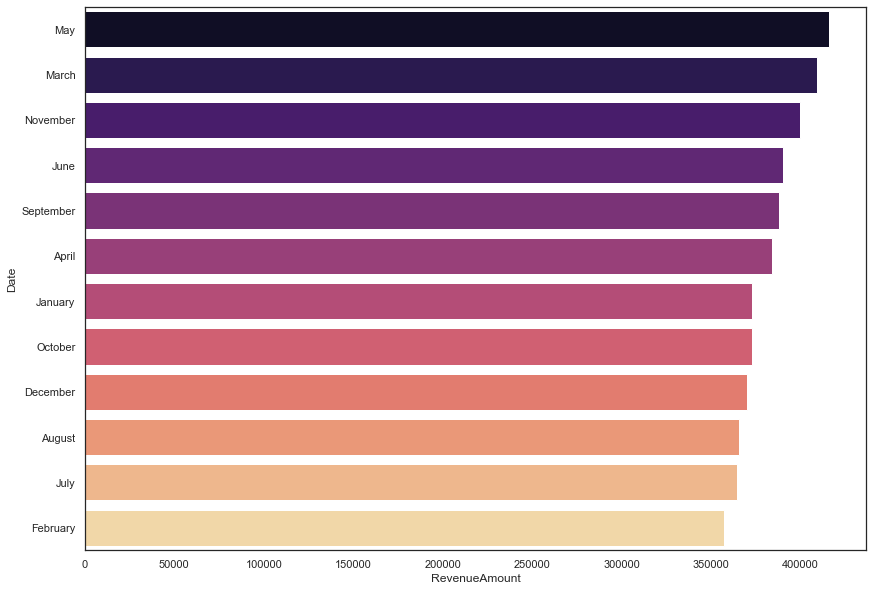

In [18]:
fig = plt.gcf()
fig.set_size_inches(14,10)

sns.barplot(x=revenue_by_month,
            y=revenue_by_month.index, palette = "magma")


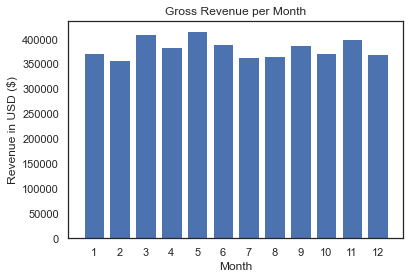

In [19]:
total = sam.groupby('Month').sum()
months = range(1,13)

plt.bar(months, total['RevenueAmount'])
plt.xticks(months)
plt.ylabel('Revenue in USD ($)')
plt.xlabel('Month')
plt.title("Gross Revenue per Month")
plt.show()

## 7. Competitor Analytics

In [20]:
competitor = competitors.groupby('Manufacturer').sum()
sorted_vals = competitor.sort_values(by='Revenue amount', ascending=False)
sorted_vals

,Revenue amount
Manufacturer,
Competitor_7,63583198.0
SAM_Labs,22793300.0
Competitor_3,20034044.0
Competitor_8,14148060.0
Competitor_4,8705686.0
Competitor_9,2733336.0
Competitor_1,1473216.0
Competitor_5,1393605.0
Competitor_2,636939.8


## 7.1 Gross Revenue USD for competitors
- SAM labs: 2nd
- All values in millions 
- 6 represents 60 Million and so on.

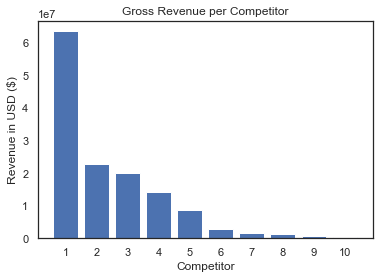

In [21]:

manufacturer = range(1,11)
#labels = ['Competitor_1', 'Competitor_2', 'Competitor_3','Competitor_4', 'Competitor_5', 'Competitor_6','Competitor_7', 'Competitor_8', 'Competitor_9','SAM_Labs'] 
plt.bar(manufacturer, sorted_vals['Revenue amount'])
plt.xticks(manufacturer)
plt.ylabel('Revenue in USD ($)')
plt.xlabel('Competitor')
plt.title("Gross Revenue per Competitor")
plt.show()

## 7.2 Top Markets by Country 
- sorted highest to lowest market
- Further insights, create a table that checks correlation
to market Visibility by revenue amount to predict market size and revenue in 2021. Using Machine Learning [ Regression Model ]

In [22]:
workbook_df3 = pd.read_excel('/Users/jtc/Data_Science_Projects/SAM_labs/sam_ex.xlsx',
                           sheet_name=['Market visibility']) # add sheets seperated by comma 
mv = pd.concat(workbook_df3[frame] for frame in workbook_df3.keys())

mv.head(32)
'''
United States	52094743.2
Italy	13585888.0
Australia	12631439.2
United Kingdom	7619141.4
Belgium	6516073.8
China	5990061.4
Singapore	5044863.2
Sweden	4493998.2
Brazil	4095034.8
Canada	3359535.0
United Arab Emirates	2889372.8
Czech Republic	2765489.8
France	2197071.4
Finland	2071296.6
Hong Kong	2028972.4
Costa Rica	1952876.4
Denmark	1029747.6
Turkey	850117.0
South Africa	763952.0
Egypt	545678.2
Switzerland	499487.0
Mexico	493042.0
South Korea	484834.0
Spain	461732.0
Oman	248088.0
Norway	230469.0
Greece	216800.6
Qatar	212479.0
New Zealand	192640.0
Russia	172973.2
Japan	137359.0
Austria	83976.6
'''

#TotalRevenue = [# fill with country revenue]
#mv['TotalRevenue'] = TotalRevenue
mv.sort_values(by="Estimated market visibility",ascending=False)
untapped_market = np.subtract(mv['Estimated market visibility'],1)

untapped_market = np.absolute(untapped_market)
#total_market_size = untapped_market * highest_country['Revenue amount']
untapped_market

0     0.21
1     0.28
2     0.22
3     0.34
4     0.64
5     0.77
6     0.53
7     0.54
8     0.44
9     0.28
10    0.49
11    0.27
12    0.37
13    0.51
14    0.35
15    0.54
16    0.46
17    0.53
18    0.68
19    0.44
20    0.55
21    0.65
22    0.38
23    0.62
24    0.28
25    0.79
26    0.53
27    0.35
28    0.67
29    0.74
30    0.26
31    0.56
Name: Estimated market visibility, dtype: float64

In [23]:
# calculate the estimated_missing_market_size
'''
estimated_missing_market_size = (0.21 * 12631439.2)
total_market = estimated_missing_market_size + 12631439.2
total_market
'''

'\nestimated_missing_market_size = (0.21 * 12631439.2)\ntotal_market = estimated_missing_market_size + 12631439.2\ntotal_market\n'

I believe that there is a high correlation here but I will need to transform the data in a way that accounts for transactions and further insights to see that data.

In [24]:
mv.corr()

,Estimated market visibility
Estimated market visibility,1.0


In [25]:
highest_country = competitors.groupby('Country').sum()
highest_country.sort_values(by='Revenue amount', axis=0, ascending=False)
highest_country['Revenue amount']


Country
Australia               12631439.2
Austria                    83976.6
Belgium                  6516073.8
Brazil                   4095034.8
Canada                   3359535.0
China                    5990061.4
Costa Rica               1952876.4
Czech Republic           2765489.8
Denmark                  1029747.6
Egypt                     545678.2
Finland                  2071296.6
France                   2197071.4
Greece                    216800.6
Hong Kong                2028972.4
Italy                   13585888.0
Japan                     137359.0
Mexico                    493042.0
New Zealand               192640.0
Norway                    230469.0
Oman                      248088.0
Qatar                     212479.0
Russia                    172973.2
Singapore                5044863.2
South Africa              763952.0
South Korea               484834.0
Spain                     461732.0
Sweden                   4493998.2
Switzerland               499487.0
Turkey      

In [26]:
comp_revenue_by_month = competitors.groupby(competitors['Date'].dt.strftime('%B'))['Revenue amount'].sum().sort_values(ascending=False)

comp_revenue_by_month 

Date
February     12551097.0
January      12478536.4
May          12412830.6
September    11919210.8
November     11451615.8
October      11281831.0
August       11211110.8
April        10900435.6
June         10802402.0
March        10572149.8
December     10341493.6
July         10036519.4
Name: Revenue amount, dtype: float64

## 8. Best Revenue Months Competitors
- Data based on competitor and SAM labs

<AxesSubplot:xlabel='Revenue amount', ylabel='Date'>

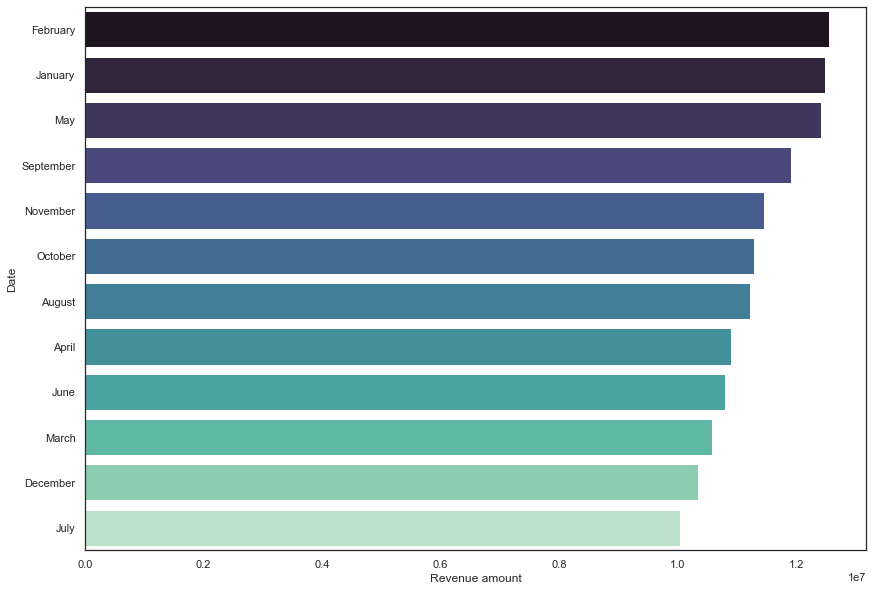

In [27]:
fig = plt.gcf()
fig.set_size_inches(14,10)

sns.barplot(x=comp_revenue_by_month,
            y=comp_revenue_by_month.index, palette = "mako")

In [28]:
def dynamic(Revenue_by_month):
    total.loc[Revenue_by_month].iplot(
                        xTitle='Month',
                        yTitle='Revenue',
                        title='Gross Revenue Per Month')

In [29]:
total.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Month')

In [30]:
@interact
def show_month_order(column='Month', x=4):
    return sam.loc[sam[column]]

interactive(children=(Text(value='Month', description='column'), IntSlider(value=4, description='x', max=12, m…

## 9. Error in the dataset: One school has incorrect country tag.
    - Tag Original Country by creating a row.
    - Group customer name and country
    - if original country not equal current then flag.
    - This will work on any dataframe where there is a mistakenly inputed country


In [31]:
sam['OriginalCountry'] = sam.groupby(['CustomerName'])['Country'].transform('first')
sam[sam['OriginalCountry']!= sam['Country']]

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup,OriginalCountry
706,School 706,SAM_LABS_707,Italy,2095,2020-04-29,4,2020-04,2020-01,United States


## 9.1 Update Country to United States
    -Contact School to make sure order was recieved.

In [32]:
sam.iloc[706]

CustomerName                School 706
OrderNumber               SAM_LABS_707
Country                          Italy
RevenueAmount                     2095
Date               2020-04-29 00:00:00
Month                                4
OrderPeriod                    2020-04
CohortGroup                    2020-01
OriginalCountry          United States
Name: 706, dtype: object

In [33]:
sam.loc[sam['CustomerName'] == 'School 706', 'Country'] = 'United States'

In [34]:
sam.iloc[706]

CustomerName                School 706
OrderNumber               SAM_LABS_707
Country                  United States
RevenueAmount                     2095
Date               2020-04-29 00:00:00
Month                                4
OrderPeriod                    2020-04
CohortGroup                    2020-01
OriginalCountry          United States
Name: 706, dtype: object

Cleaning Data [Text Preprocessing]
- adjusting ['Revenue amount'] using regular expressions, removing '$' and casting data type as integer.

- print for changes.

In [35]:
# if you are using the faster implementation do not run this cell 
# sam['Revenue amount'] = sam['Revenue amount'].str.replace(r'\D','').astype(int)

Evaluate Data Types for changes 
- ['Revenue amount'] is now int64 

In [36]:
# if you are using the faster implementation do not run this cell 
# print(sam.info())

# 10. Annual Summary 
    -  Biggest Clients who are returning customers.
    -  Smallest Clients who are returning customers.
    -  Order # 1158 is the largest
    -  Life Time Value 

### 10.1 Top 20% of Individual Orders

    - Largest Indivdual Transaction:
    - Customer: School 1484 , Revenue: $8004 Date: 2020-06-30	

In [37]:
largest = sam.sort_values(by='RevenueAmount', ascending=False).head(332)
largest

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup,OriginalCountry
1157,School 1484,SAM_LABS_1158,Australia,8004,2020-06-30,6,2020-06,2020-03,Australia
915,School 916,SAM_LABS_916,Singapore,3000,2020-07-20,7,2020-07,2020-02,Singapore
1712,School 1713,SAM_LABS_1713,Australia,2999,2020-08-16,8,2020-08,2020-08,Australia
1613,School 1614,SAM_LABS_1614,United States,2999,2020-06-04,6,2020-06,2020-06,United States
627,School 628,SAM_LABS_628,United States,2998,2020-09-24,9,2020-09,2020-09,United States
1025,School 1026,SAM_LABS_1026,United Kingdom,2998,2020-12-02,12,2020-12,2020-01,United Kingdom
323,School 230,SAM_LABS_324,Singapore,2997,2020-04-22,4,2020-04,2020-01,Singapore
211,School 212,SAM_LABS_212,Belgium,2997,2020-08-22,8,2020-08,2020-08,Belgium
887,School 888,SAM_LABS_888,United States,2997,2020-10-19,10,2020-10,2020-10,United States
1729,School 1730,SAM_LABS_1730,United States,2995,2020-09-02,9,2020-09,2020-09,United States


In [38]:
largest.nunique()

# 317 Distinct Customers 
# 15 Returning Customers

CustomerName       317
OrderNumber        332
Country             26
RevenueAmount      175
Date               215
Month               12
OrderPeriod         12
CohortGroup         12
OriginalCountry     26
dtype: int64

In [39]:
largest.groupby(['CustomerName','RevenueAmount'])

### 10.3 Highest Revenue Returning Client Orders
    - Ordered multiple times within the top 20% of orders for one year.

In [40]:
repeated = largest.duplicated(subset = 'CustomerName', keep = False)
largest[repeated].sort_values(by=['CustomerName'], ascending = False)

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup,OriginalCountry
1188,School 916,SAM_LABS_1189,Singapore,2920,2020-11-24,11,2020-11,2020-02,Singapore
915,School 916,SAM_LABS_916,Singapore,3000,2020-07-20,7,2020-07,2020-02,Singapore
691,School 653,SAM_LABS_692,Sweden,2992,2020-11-13,11,2020-11,2020-03,Sweden
653,School 653,SAM_LABS_654,Sweden,2819,2020-05-29,5,2020-05,2020-03,Sweden
642,School 643,SAM_LABS_643,Czech Republic,2936,2020-06-01,6,2020-06,2020-06,Czech Republic
675,School 643,SAM_LABS_676,Czech Republic,2975,2020-12-06,12,2020-12,2020-06,Czech Republic
497,School 498,SAM_LABS_498,China,2824,2020-03-20,3,2020-03,2020-02,China
518,School 498,SAM_LABS_519,China,2779,2020-02-01,2,2020-02,2020-02,China
435,School 304,SAM_LABS_436,Brazil,2896,2020-11-12,11,2020-11,2020-01,Brazil
303,School 304,SAM_LABS_304,Brazil,2831,2020-09-30,9,2020-09,2020-01,Brazil


## 10.4 Bottom 20% of Orders

In [41]:
smallest = sam.sort_values(by='RevenueAmount', ascending=False).tail(332)
smallest

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup,OriginalCountry
380,School 381,SAM_LABS_381,United States,1760,2020-10-02,10,2020-10,2020-10,United States
1032,School 1033,SAM_LABS_1033,Belgium,1759,2020-01-09,1,2020-01,2020-01,Belgium
1330,School 1331,SAM_LABS_1331,United Arab Emirates,1759,2020-10-13,10,2020-10,2020-10,United Arab Emirates
383,School 384,SAM_LABS_384,United States,1756,2020-02-09,2,2020-02,2020-02,United States
553,School 554,SAM_LABS_554,Mexico,1756,2020-03-10,3,2020-03,2020-03,Mexico
1974,School 1942,SAM_LABS_1975,Singapore,1756,2020-11-07,11,2020-11,2020-10,Singapore
673,School 673,SAM_LABS_674,Brazil,1756,2020-10-03,10,2020-10,2020-07,Brazil
402,School 403,SAM_LABS_403,United States,1755,2020-04-22,4,2020-04,2020-04,United States
926,School 927,SAM_LABS_927,Australia,1755,2020-09-08,9,2020-09,2020-09,Australia
1232,School 1233,SAM_LABS_1233,United States,1754,2020-08-12,8,2020-08,2020-08,United States


## 10.5 Lowest Revenue Returning Client Orders

In [42]:
repeated = smallest.duplicated(subset = 'CustomerName', keep = False)
smallest[repeated].sort_values(by=['CustomerName'], ascending = False)

,CustomerName,OrderNumber,Country,RevenueAmount,Date,Month,OrderPeriod,CohortGroup,OriginalCountry
85,School 85,SAM_LABS_86,United States,1540,2020-01-30,1,2020-01,2020-01,United States
84,School 85,SAM_LABS_85,United States,1582,2020-12-04,12,2020-12,2020-01,United States
178,School 8,SAM_LABS_179,United States,1606,2020-12-15,12,2020-12,2020-04,United States
702,School 8,SAM_LABS_703,United States,1562,2020-08-09,8,2020-08,2020-04,United States
679,School 8,SAM_LABS_680,United States,1518,2020-12-19,12,2020-12,2020-04,United States
938,School 706,SAM_LABS_939,United States,1685,2020-09-23,9,2020-09,2020-01,United States
906,School 706,SAM_LABS_907,United States,1536,2020-01-13,1,2020-01,2020-01,United States
908,School 706,SAM_LABS_909,United States,1605,2020-01-25,1,2020-01,2020-01,United States
337,School 336,SAM_LABS_338,United Kingdom,1675,2020-07-09,7,2020-07,2020-07,United Kingdom
336,School 336,SAM_LABS_337,United Kingdom,1676,2020-11-24,11,2020-11,2020-07,United Kingdom


## 10.6 Percentage of schools that placed more than one order

In [43]:
morethan1 = sam.groupby('CustomerName').count()['OrderNumber'] > 1
morethan1.sum() # 257 Schools placed more than one order

sam['CustomerName'].nunique() # 1664 Unique Customer

returning_customers = 257
unique_customers = 1664

percentMoreThanOne = np.round(returning_customers/unique_customers,2)

print(percentMoreThanOne,"%")

0.15 %


## 11. Calculating LTV
- Lifetime value = average value of sale * average number of transaction * rentention time period ( number of appearances in the year )

### 11.1 Massive Outlier

- Remove before calculating LTV

Customer: School 1484 , Revenue: $8004 Date: 2020-06-30	

 Removing outlier value before calculating average value of sale.

In [44]:
removeoutlier_sam = sam.drop(1157)
removeoutlier_sam.max() # check for removed row 

CustomerName                School 999
OrderNumber               SAM_LABS_999
Country                  United States
RevenueAmount                     3000
Date               2020-12-31 00:00:00
Month                               12
OrderPeriod                    2020-12
CohortGroup                    2020-12
OriginalCountry          United States
dtype: object

In [45]:
numOfTrans = removeoutlier_sam.groupby('CustomerName').count()
numOfTrans['OrderNumber'].sum() # 2023 total orders

2023

In [46]:
removeoutlier_sam['RevenueAmount'].sum()
print("$",removeoutlier_sam['RevenueAmount'].sum())

$ 4584611


In [47]:
total_reveue_2020 = 4584611 

total_orders = 2023

Average_Value_of_Sale = np.round(total_reveue_2020 / total_orders,2)

Average_customer_orders = 1.21

print("$",Average_Value_of_Sale)


$ 2266.24


In [48]:
print("$",np.round(Average_Value_of_Sale * Average_customer_orders,2))

$ 2742.15


Total Revenue 2020 : $4,584,611 

Average customer spends 4,584,611 / 2023 = $ 2266.24

Average customer orders 1.21 times per year with SAM labs. (transactions)

Average LTV: $ 2742.15

## Extras: Intuitive Implementation of Data Frame Manipulation
### Dynamic Tool to sort by month.
    - Use this tool to render the entire Data Frame with interactive controls.
    - Use this tool to do specific look up and groupings of data with-out the need to hardcode.

In [49]:
qgrid_widget = qgrid.show_grid(competitors, show_toolbar = True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Extras Dynamic Tool to Graph analytics by month or any partiular value 

In [50]:
# Dynamic tool 
interact(dynamic,Revenue_by_month=total.index)

interactive(children=(Dropdown(description='Revenue_by_month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)…

<function __main__.dynamic(Revenue_by_month)>

SyntaxError: invalid syntax (<ipython-input-1-14415da0c84b>, line 1)